<a href="https://colab.research.google.com/github/dauuuum/log-analysis/blob/main/onlineshop_log_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Importing modules and data**

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install plotly==4.*
    !pip install pdpbox

     |████████████████████████████████| 82 kB 164 kB/s 
     |████████████████████████████████| 34.0 MB 180 kB/s 
     |████████████████████████████████| 13.1 MB 25.5 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758225 sha256=0381829a6fd5a005ace3b46c116d6099e72f08d6fe7541ccb64739a27c903f31
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import pandas_profiling

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns

from category_encoders import OrdinalEncoder
from category_encoders import OneHotEncoder
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import xgboost
from xgboost import XGBClassifier

import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 무시
pd.set_option('mode.chained_assignment', None) # SettingWithCopyError 무시

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 데이터셋 불러오기
df1 = pd.read_csv('/content/drive/MyDrive/2020-Jan.csv')
df2 = pd.read_csv('/content/drive/MyDrive/2020-Feb.csv')

### **EDA**

**칼럼 설명**

|Features|Description|
|--|--|
|event_time|행동이 발생한 시간|
|event_type|purchase, cart, view, remove_cart 행동 중 1개|
|product_id|상품 ID|
|category_id|상품의 카테고리 ID|
|category_code|상품의 카테고리명|
|brand|브랜드명|
|price|상품의 가격|
|user_id|영구적인 사용자 ID|
|user_session|일시적인 사용자의 세션 ID|


In [5]:
# 데이터셋 합치기 
df = pd.concat([df1,df2])
print(df.shape)
df.head()

(8421434, 9)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-01-01 00:00:00 UTC,view,5809910,1602943681873052386,NaN,grattol,5.24,595414620,4adb70bb-edbd-4981-b60f-a05bfd32683a
1,2020-01-01 00:00:09 UTC,view,5812943,1487580012121948301,NaN,kinetics,3.97,595414640,c8c5205d-be43-4f1d-aa56-4828b8151c8a
2,2020-01-01 00:00:19 UTC,view,5798924,1783999068867920626,NaN,zinger,3.97,595412617,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3
3,2020-01-01 00:00:24 UTC,view,5793052,1487580005754995573,NaN,NaN,4.92,420652863,546f6af3-a517-4752-a98b-80c4c5860711
4,2020-01-01 00:00:25 UTC,view,5899926,2115334439910245200,NaN,NaN,3.92,484071203,cff70ddf-529e-4b0c-a4fc-f43a749c0acb


In [6]:
# 데이터 타입 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8421434 entries, 0 to 4156681
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 642.5+ MB


In [7]:
# 데이터 결측치 확인
df.isnull().sum()

event_time             0
event_type             0
product_id             0
category_id            0
category_code    8269530
brand            3601538
price                  0
user_id                0
user_session        2369
dtype: int64

In [8]:
# 전처리
def preprocess(df): 
    # 1) int to string
    df['product_id'] = pd.to_numeric(df['product_id'])
    df['category_id'] = pd.to_numeric(df['category_id'])
    df['user_id'] = pd.to_numeric(df['user_id'])

    # 2) event_time type - object to datetime
    df['event_time'] = df['event_time'].apply(lambda d: str(d)[0:19]) # UTC 제거
    df['event_time'] = pd.to_datetime(df['event_time'])
    
    # 3) 결측률 높은 특성 제거
    labels = df.isnull().mean()
    selected_features = labels[labels <= 0.5].index.tolist()
    df = df[selected_features]

    # 4) brand 컬럼 - 결측값 대체
    df['brand'] = df['brand'].replace(np.nan,'Not Available')

    # 5) 주문번호 컬럼 생성
    df['ordernumber'] = df['user_id'] + df['product_id'] + df['category_id']

    return df

data = preprocess(df)
data.shape

(8421434, 9)

In [9]:
# 데이터 규모
print(df.shape[0])
print(df['user_id'].nunique()) # 사용자
print(df['product_id'].nunique()) # 제품
print(df[(df.event_type =='purchase')].shape[0]) # 구매

8421434
737093
50924
505790


### **Plot for EDA**

In [10]:
# 페이지뷰
pv = df['event_type'].value_counts()
pv = pd.DataFrame({'page_view':pv})
pv

,page_view
view,3991194
cart,2297017
remove_from_cart,1627433
purchase,505790


conversion rate:  0.13


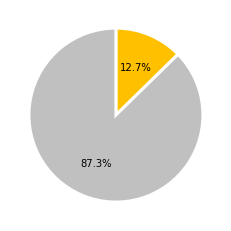

In [11]:
# 구매전환율
cvr = pv.loc['purchase']['page_view'] / pv.loc['view']['page_view']
print('conversion rate: ', round(cvr, 2))

%matplotlib inline 
ratio = [cvr*100, 100-(cvr*100)]
labels = ['conversion_rate', '']
colors = ['#ffc000', '#c0c0c0']
wedgeprops={'edgecolor': 'w', 'linewidth': 3}

plt.pie(ratio, autopct='%.1f%%', startangle=90, counterclock=False, colors=colors, wedgeprops=wedgeprops)
plt.show()

,page_view,bounce,bounce_rate
view,3991194,1200883,30.088314
cart,2297017,25306,1.101690
remove_from_cart,1627433,4036,0.247998
purchase,505790,549,0.108543


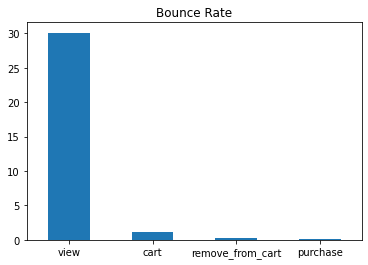

In [12]:
# 이탈율
count = {}
lists = [i for i in df['user_session']]
for i in lists:
    try: count[i] += 1
    except: count[i] = 1

lists2 = [key for key, value in count.items() if value == 1]
bounce = pd.DataFrame({'user_session':lists2})
bounce = pd.merge(bounce, df[['user_session','event_type']], on='user_session', how='left')
bounce = bounce['event_type'].value_counts()
bounce = pd.DataFrame({'bounce':bounce})

bounce_rate = pd.concat([pv, bounce], axis=1)
bounce_rate['bounce_rate'] = (bounce_rate['bounce'] / bounce_rate['page_view'])*100
bounce_rate['bounce_rate'].plot(kind='bar',rot=0,title='Bounce Rate');

bounce_rate

### **Finding**
* 'view'에서 사용자가 단일 페이지만 보고 페이지를 이탈하는 비율이 가장 높습니다.

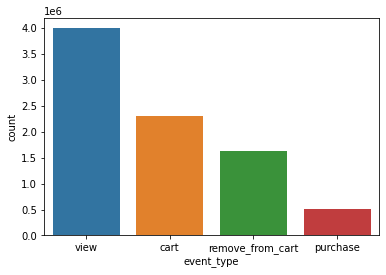

In [13]:
# 고객 행동 단계별 비율
customer_behavior = df['event_type'].value_counts().reset_index().rename(columns={'index':'event_type','event_type':'count'})
sns.barplot(data=customer_behavior, x='event_type', y='count');

In [14]:
# 고객 행동 단계별 비율(funnel)
fig = px.funnel(customer_behavior, x='count', y='event_type')
fig.update_traces(texttemplate='%{x:.f}')
fig.show()

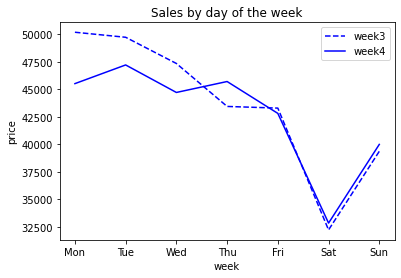

In [15]:
# 요일별 매출 합계
data_time = data[data['event_type'].isin(['purchase'])][['event_time','price']]
data_time = pd.DataFrame(data_time)

data_time['weekday'] = [i.isocalendar() for i in data_time['event_time']]
data_time['weekly'] = ['week'+str(i[1]) for i in data_time['weekday']]
data_time['week'] = [i[2] for i in data_time['weekday']]

def price_by_week(week):
  df = data_time[data_time['weekly']==week].groupby(['week'])['price'].sum()
  df = pd.DataFrame(df)
  return df

week3 = price_by_week('week3')
week4 = price_by_week('week4')

plt.plot(week3.index, week3['price'], 'b', linestyle='dashed', label='week3')
plt.plot(week4.index, week4['price'], 'b', linestyle='solid', label='week4')
plt.xticks([1,2,3,4,5,6,7], labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.xlabel('week')
plt.ylabel('price')
plt.title('Sales by day of the week')
plt.legend(loc='upper right')

plt.show()

### **Finding**
* 1월 4주차는 전주 대비 매출이 역성장 추세를 보이고 있습니다. 특히 '월요일'에 전주 대비 -10% 역성장으로 매출이 크게 하락하였습니다.

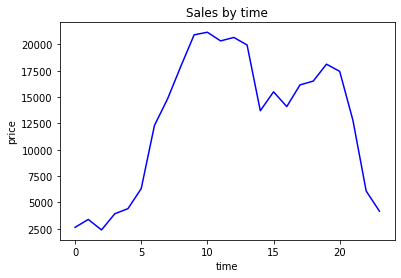

In [16]:
# 시간별 매출 합계
data_time['time'] = [i.hour for i in data_time['event_time']]

def price_by_time(week):
  df = data_time[data_time['weekly']==week].groupby(['time'])['price'].sum()
  df = pd.DataFrame(df)
  return df

week3 = price_by_time('week3')

plt.plot(week3.index, week3['price'], 'b', linestyle='solid', label='week3')
plt.xlabel('time')
plt.ylabel('price')
plt.title('Sales by time')

plt.show()

### **Finding**
*   피크 타임은 일 2회로 오전 10시, 오후 7시에 판매가 높았습니다.
*   오전 10시에 2.2만 달러로 일 최대 매출 기록하였습니다.




### **Feature Engineering**

**칼럼 설명**

|Features|Description|
|--|--|
|user_id|영구적인 사용자 ID|
|category_id|상품의 카테고리 ID|
|product_id|상품 ID|
|view|상품 보기 총 횟수|
|cart|장바구니에 담은 총 횟수|
|remove_from_cart|장바구니에 제거한 총 횟수|
|price|상품의 가격|
|first_time|상품 보기 페이지에 처음 접근한 시간|
|last_time|상품 보기 페이지에 마지막 접근한 시간|
|dif_time|상품 보기 페이지에 마지막 접근한 시간 - 상품 보기 페이지에 처음 접근한 시간|
|pur_time|구매한 시간|
|purchase_status|사용자의 상품 최종 구매 여부|


In [17]:
# 특성 엔지니어링
def feature_engineering(df): 
    # 1) crosstab
    dataset = pd.crosstab(index=[df.user_id, df.category_id, df.product_id], columns=df.event_type).reset_index()

    # 2) 주문번호 컬럼 생성
    dataset['ordernumber'] = dataset['user_id'] + dataset['product_id'] + dataset['category_id']

    # 3) 가격/구매시간 컬럼 추가
    price = data.groupby(['ordernumber'])['price'].last().reset_index(name = 'price')
    dataset = pd.merge(dataset, price, on='ordernumber', how='left')

    pur_time = data[(data['event_type']=='purchase')].groupby(['ordernumber'])['event_time'].last().reset_index(name = 'pur_time')
    dataset = pd.merge(dataset, pur_time, on='ordernumber', how='left')

    # 4) first_time, last_time 컬럼 생성
    first_time = data[(data['event_type']=='view')].groupby(['ordernumber'])['event_time'].first().reset_index(name = 'first_time')
    last_time = data[(data['event_type']=='view')].groupby(['ordernumber'])['event_time'].last().reset_index(name = 'last_time')

    dataset = pd.merge(dataset, first_time, on='ordernumber', how='left')
    dataset = pd.merge(dataset, last_time, on='ordernumber', how='left')

    # 5) purchase_status 컬럼 생성
    dataset['purchase_status'] = dataset['purchase_status'] = [1 if i >= 1 else 0 for i in dataset['purchase']]

    # 6) dif_time 컬럼 생성
    dataset['dif_time'] = (dataset['last_time'] - dataset['first_time']).dt.seconds / 60 
    dataset['dif_time'] = dataset['dif_time'].replace(np.nan, 0)

    # 7) Overfitting 방지
    dataset.drop(columns=['purchase','ordernumber'], inplace=True)

    return dataset

dataset = feature_engineering(data)
dataset.shape
dataset.head()

,user_id,category_id,product_id,cart,remove_from_cart,view,price,pur_time,first_time,last_time,purchase_status,dif_time
0,465496,1487580008447738866,5769989,0,0,1,10.00,NaT,2020-01-14 16:25:35,2020-01-14 16:25:35,0,0.0
1,465496,1487580008447738866,5865524,0,0,1,10.00,NaT,2020-01-14 16:27:31,2020-01-14 16:27:31,0,0.0
2,465496,1487580008447738866,5865526,0,0,1,10.00,NaT,2020-01-14 16:15:21,2020-01-14 16:15:21,0,0.0
3,2038666,1487580011534745720,5867581,0,0,1,25.38,NaT,2020-02-16 13:19:37,2020-02-16 13:19:37,0,0.0
4,3571443,1487580008112194531,5814877,0,0,1,2.78,NaT,2020-02-26 19:11:57,2020-02-26 19:11:57,0,0.0


### **Check correlation**

In [18]:
dataset.corr(method='pearson')

,user_id,category_id,product_id,cart,remove_from_cart,view,price,purchase_status,dif_time
user_id,1.000000,0.012940,-0.015513,-0.041761,-0.072045,0.025101,0.038125,-0.054653,-0.011755
category_id,0.012940,1.000000,0.012181,-0.023160,-0.015679,0.014077,0.008247,-0.011210,0.003573
product_id,-0.015513,0.012181,1.000000,0.006922,0.017858,0.003971,-0.020598,-0.005530,0.007877
cart,-0.041761,-0.023160,0.006922,1.000000,0.366182,-0.092956,-0.109674,0.274387,0.024585
remove_from_cart,-0.072045,-0.015679,0.017858,0.366182,1.000000,-0.075017,-0.086902,-0.059450,0.026439
view,0.025101,0.014077,0.003971,-0.092956,-0.075017,1.000000,0.092727,-0.050957,0.414616
price,0.038125,0.008247,-0.020598,-0.109674,-0.086902,0.092727,1.000000,-0.078181,0.032375
purchase_status,-0.054653,-0.011210,-0.005530,0.274387,-0.059450,-0.050957,-0.078181,1.000000,0.028004
dif_time,-0.011755,0.003573,0.007877,0.024585,0.026439,0.414616,0.032375,0.028004,1.000000


### **Finding**
*   'cart' 장바구니에 담은 총 횟수가 구매 여부와 높은 상관 관계를 가지고 있습니다. 

### **Modeling**

In [19]:
dataset['pur_time'] = pd.to_datetime(dataset['first_time']).map(dt.datetime.toordinal)
dataset['first_time'] = pd.to_datetime(dataset['first_time']).map(dt.datetime.toordinal)
dataset['last_time'] = pd.to_datetime(dataset['last_time']).map(dt.datetime.toordinal)

In [20]:
# target baseline
target = 'purchase_status'
features = dataset.drop(columns=[target]).columns
X_train = dataset[features]
y_train = dataset[target]

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.4, shuffle=False)

major = y_train.mode()[0]
y_pred = [major]*len(y_train)

print('기준 모델 F1 score: {0:.4f}'.format(f1_score(y_train, y_pred)))
print(classification_report(y_train, y_pred))

# target 비율
dataset[target].value_counts(normalize=True) # 데이터 불균형

기준 모델 F1 score: 0.0000
              precision    recall  f1-score   support

           0       0.87      1.00      0.93   2267403
           1       0.00      0.00      0.00    324594

    accuracy                           0.87   2591997
   macro avg       0.44      0.50      0.47   2591997
weighted avg       0.77      0.87      0.82   2591997



0    0.887041
1    0.112959
Name: purchase_status, dtype: float64

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.4, shuffle=False)

In [22]:
# XGB Classifier
model1 = XGBClassifier(max_depth=10, scale_pos_weight=99)

model1.fit(X_train, y_train);

pred_xgb = model1.predict(X_test)

accuracy = accuracy_score(y_test, pred_xgb)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('F1 score: ', f1_score(y_test, pred_xgb))
print(classification_report(y_test, pred_xgb))

Accuracy: 69.05%
F1 score:  0.40841144239349264
              precision    recall  f1-score   support

           0       0.99      0.66      0.79    918729
           1       0.26      0.94      0.41    118070

    accuracy                           0.69   1036799
   macro avg       0.62      0.80      0.60   1036799
weighted avg       0.91      0.69      0.75   1036799



In [23]:
# GridSearchCV
params = {'max_depth': [5, 10, 15],
          'min_child_weight': [1,3,5],
          'n_estimators': [100,200,500],
          'scale_pos_weight': [1, 0.1, 0.01]}
m = XGBClassifier(class_weight='balanced')
grid_cv = GridSearchCV(m, param_grid=params, scoring='f1', cv=3)
grid_cv.fit(X_train, y_train)

best1 = grid_cv.best_estimator_
pred1 = best1.predict(X_test)
print(best1)

accuracy = accuracy_score(y_test, pred1)
print('Accuracy: %.2f%%' % (accuracy * 100.0))
print('F1 score: ', f1_score(y_test, pred1))
print(classification_report(y_test, pred1))

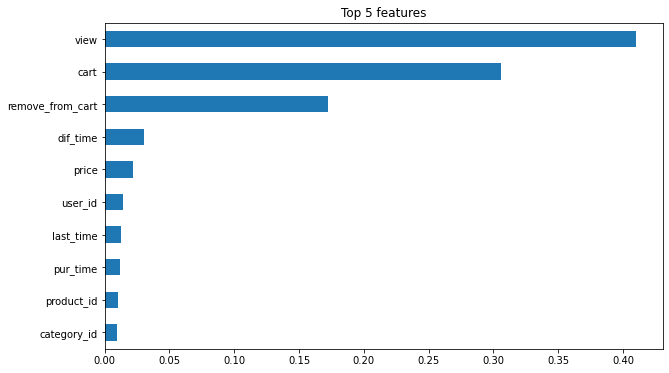

In [24]:
# Feature Importance
importances_xgb = pd.Series(model1.feature_importances_, X_train.columns)

plt.figure(figsize=(10, 6))
plt.title(f'Top {5} features')
importances_xgb.sort_values()[-10:].plot.barh();

### **Finding**
*   'cart' 장바구니에 담은 총 횟수가 구매 여부와 높은 특성 유사도를 보입니다.

In [25]:
## 데이터 불균형 해결(1)
# SMOTE
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

model = XGBClassifier(max_depth=10, scale_pos_weight=99)
xgb_smote = model.fit(X_smote, y_smote)

pred_over = xgb_smote.predict(X_test)

accuracy = accuracy_score(y_test, pred_over)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('검증 정확도: ', f1_score(y_test, pred_over))
print(classification_report(y_test, pred_over))

Accuracy: 73.52%
검증 정확도:  0.4517675158917662
              precision    recall  f1-score   support

           0       0.99      0.71      0.83    918729
           1       0.30      0.96      0.45    118070

    accuracy                           0.74   1036799
   macro avg       0.64      0.83      0.64   1036799
weighted avg       0.91      0.74      0.78   1036799



In [26]:
## 데이터 불균형 해결(2)
# RandomOverSampling
oversample = RandomOverSampler(sampling_strategy=0.5)
X_over, y_over = oversample.fit_resample(X_train, y_train)

model = XGBClassifier(max_depth=10, scale_pos_weight=99)
xgb_over = model.fit(X_over, y_over)

pred_over = xgb_over.predict(X_test)

accuracy = accuracy_score(y_test, pred_over)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('검증 정확도: ', f1_score(y_test, pred_over))
print(classification_report(y_test, pred_over))

Accuracy: 65.20%
검증 정확도:  0.37851031541377933
              precision    recall  f1-score   support

           0       0.99      0.62      0.76    918729
           1       0.24      0.93      0.38    118070

    accuracy                           0.65   1036799
   macro avg       0.61      0.77      0.57   1036799
weighted avg       0.90      0.65      0.72   1036799



In [27]:
## 데이터 불균형 해결(3)
# RandomUnderSampling
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_under, y_under = undersample.fit_resample(X_train, y_train)

model = DecisionTreeClassifier()
xgb_under = model.fit(X_under, y_under)

pred_under = xgb_under.predict(X_test)

accuracy = accuracy_score(y_test, pred_under)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('검증 정확도: ', f1_score(y_test, pred_under))
print(classification_report(y_test, pred_under))

Accuracy: 73.94%
검증 정확도:  0.3742063997591115
              precision    recall  f1-score   support

           0       0.95      0.75      0.84    918729
           1       0.26      0.68      0.37    118070

    accuracy                           0.74   1036799
   macro avg       0.60      0.72      0.60   1036799
weighted avg       0.87      0.74      0.78   1036799



In [28]:
# Random Forest Classifier
model2 = RandomForestClassifier(max_depth=5, class_weight='balanced')

model2.fit(X_train, y_train);

pred_rf = model2.predict(X_test)

accuracy = accuracy_score(y_test, pred_rf)
print('Accuracy: %.2f%%' % (accuracy * 100.0))
print('F1 score: ', f1_score(y_test, pred_rf))
print(classification_report(y_test, pred_rf))

Accuracy: 81.73%
F1 score:  0.541489642417068
              precision    recall  f1-score   support

           0       0.99      0.80      0.89    918729
           1       0.38      0.95      0.54    118070

    accuracy                           0.82   1036799
   macro avg       0.69      0.87      0.71   1036799
weighted avg       0.92      0.82      0.85   1036799



In [29]:
# GridSearchCV
params = {
    'max_depth' : [5, 8, 10],
    'min_samples_split' : [16, 24]
}

m = RandomForestClassifier(class_weight='balanced')
grid_cv = GridSearchCV(m, param_grid=params, scoring='f1', cv=3)
grid_cv.fit(X_train, y_train)

best2 = grid_cv.best_estimator_
pred2 = best2.predict(X_test)
print(best2)

accuracy = accuracy_score(y_test, pred2)
print('Accuracy: %.2f%%' % (accuracy * 100.0))
print('F1 score: ', f1_score(y_test, pred2))
print(classification_report(y_test, pred2))

RandomForestClassifier(class_weight='balanced', max_depth=8,
                       min_samples_split=16)
Accuracy: 83.06%
F1 score:  0.5587891787624044
              precision    recall  f1-score   support

           0       0.99      0.82      0.90    918729
           1       0.40      0.94      0.56    118070

    accuracy                           0.83   1036799
   macro avg       0.69      0.88      0.73   1036799
weighted avg       0.92      0.83      0.86   1036799



In [30]:
## 데이터 불균형 해결(1)
# RandomOverSampling
oversample = RandomOverSampler(sampling_strategy=0.5)
X_over, y_over = oversample.fit_resample(X_train, y_train)

model = RandomForestClassifier(max_depth=5, class_weight='balanced')
rf_over = model.fit(X_over, y_over)

pred_over = rf_over.predict(X_test)

accuracy = accuracy_score(y_test, pred_over)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('검증 정확도: ', f1_score(y_test, pred_over))
print(classification_report(y_test, pred_over))

Accuracy: 82.22%
검증 정확도:  0.5479239692207312
              precision    recall  f1-score   support

           0       0.99      0.81      0.89    918729
           1       0.39      0.95      0.55    118070

    accuracy                           0.82   1036799
   macro avg       0.69      0.88      0.72   1036799
weighted avg       0.92      0.82      0.85   1036799



In [31]:
## 데이터 불균형 해결(2)
# RandomUnderSampling
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_under, y_under = undersample.fit_resample(X_train, y_train)

model = RandomForestClassifier(max_depth=5, class_weight='balanced')
rf_under = model.fit(X_under, y_under)

pred_under = rf_under.predict(X_test)

accuracy = accuracy_score(y_test, pred_under)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('검증 정확도: ', f1_score(y_test, pred_under))
print(classification_report(y_test, pred_under))

Accuracy: 81.46%
검증 정확도:  0.5379062673522222
              precision    recall  f1-score   support

           0       0.99      0.80      0.88    918729
           1       0.38      0.95      0.54    118070

    accuracy                           0.81   1036799
   macro avg       0.68      0.87      0.71   1036799
weighted avg       0.92      0.81      0.84   1036799



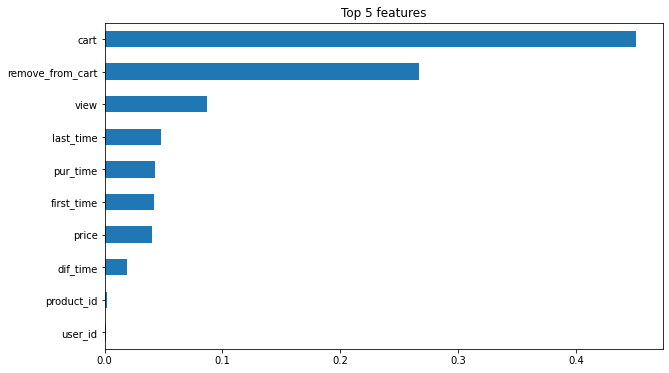

In [32]:
# Feature Importance
importances_rf = pd.Series(model2.feature_importances_, X_train.columns)

plt.figure(figsize=(10, 6))
plt.title(f'Top {5} features')
importances_rf.sort_values()[-10:].plot.barh();

### **Finding**
*   'cart' 장바구니에 담은 총 횟수가 구매 여부와 높은 특성 유사도를 보입니다.

In [33]:
# Decision Tree Classifier
model3 = DecisionTreeClassifier(max_depth=10, class_weight='balanced')

model3.fit(X_train, y_train);

pred_dt = model3.predict(X_test)

accuracy = accuracy_score(y_test, pred_dt)
print('Accuracy: %.2f%%' % (accuracy * 100.0))
print('F1 score: ', f1_score(y_test, pred_dt))
print(classification_report(y_test, pred_dt))

Accuracy: 80.51%
F1 score:  0.519413677218035
              precision    recall  f1-score   support

           0       0.99      0.79      0.88    918729
           1       0.36      0.92      0.52    118070

    accuracy                           0.81   1036799
   macro avg       0.67      0.86      0.70   1036799
weighted avg       0.92      0.81      0.84   1036799



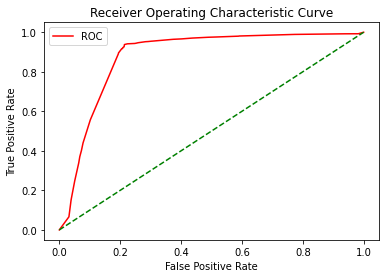

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
model =DecisionTreeClassifier(max_depth=10, class_weight='balanced')
model.fit(X_train, y_train)

prob = model.predict_proba(X_test)
prob = prob[:, 1]
fper, tper, thresholds = roc_curve(y_test, prob)
plot_roc_curve(fper, tper)

### **Finding**
*   ROC 커브의 밑면적 AUC의 넓이가 넓을 수록 그 모델의 성능이 좋다는 것을 의미한다.

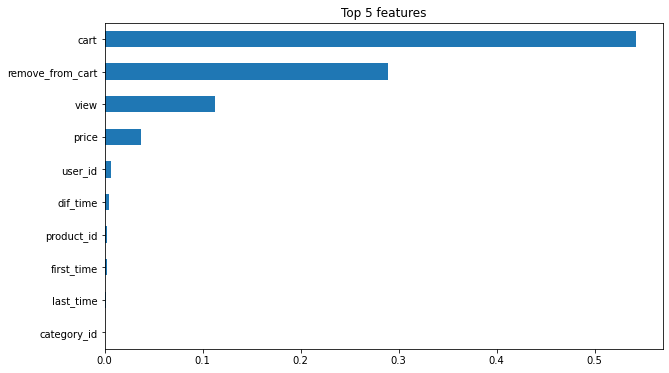

In [35]:
# Feature Importance
importances_dt = pd.Series(model3.feature_importances_, X_train.columns)

plt.figure(figsize=(10, 6))
plt.title(f'Top {5} features')
importances_dt.sort_values()[-10:].plot.barh();

### **Finding**
*   'cart' 장바구니에 담은 총 횟수가 구매 여부와 높은 특성 유사도를 보입니다.

In [36]:
## 데이터 불균형 해결(1)
# SMOTE
sm = SMOTE(sampling_strategy='auto', random_state=0)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

model = DecisionTreeClassifier(max_depth=10, class_weight='balanced')
dt_smote = model.fit(X_smote, y_smote)

pred_over = dt_smote.predict(X_test)

accuracy = accuracy_score(y_test, pred_over)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('검증 정확도: ', f1_score(y_test, pred_over))
print(classification_report(y_test, pred_over))

Accuracy: 84.09%
검증 정확도:  0.5651486150877136
              precision    recall  f1-score   support

           0       0.99      0.83      0.90    918729
           1       0.41      0.91      0.57    118070

    accuracy                           0.84   1036799
   macro avg       0.70      0.87      0.73   1036799
weighted avg       0.92      0.84      0.86   1036799



In [37]:
## 데이터 불균형 해결(2)
# RandomUnderSampling
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_under, y_under = undersample.fit_resample(X_train, y_train)

model = DecisionTreeClassifier(max_depth=10, class_weight='balanced')
dt_randomunder = model.fit(X_under, y_under)

pred_under = dt_randomunder.predict(X_test)

accuracy = accuracy_score(y_test, pred_under)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('검증 정확도: ', f1_score(y_test, pred_under))
print(classification_report(y_test, pred_under))

Accuracy: 80.86%
검증 정확도:  0.5264305619178501
              precision    recall  f1-score   support

           0       0.99      0.79      0.88    918729
           1       0.37      0.93      0.53    118070

    accuracy                           0.81   1036799
   macro avg       0.68      0.86      0.70   1036799
weighted avg       0.92      0.81      0.84   1036799



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


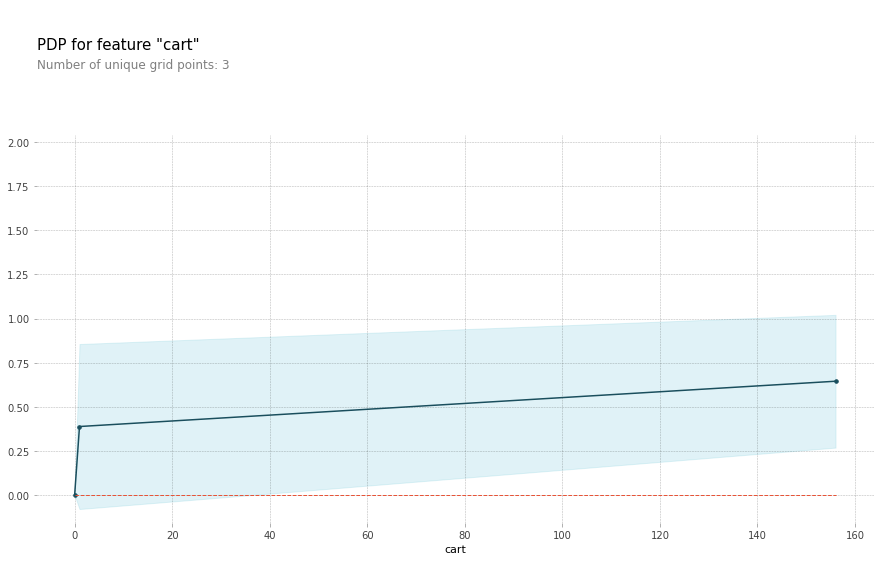

In [38]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

isolated = pdp_isolate(
        model=model3,
        dataset=X_train,
        model_features=X_train.columns,
        feature='cart',
        grid_type='percentile',
        num_grid_points= 10
        )

pdp_plot(isolated, feature_name='cart');

### **Finding**
*   'cart' 장바구니에 담은 총 횟수는 구매 여부와 양의 상관 관계를 보입니다.

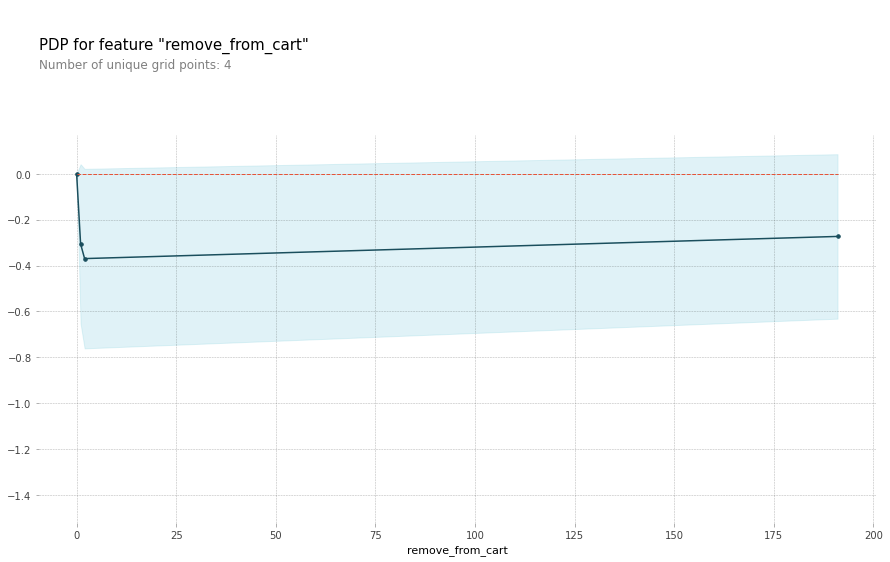

In [39]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

isolated = pdp_isolate(
        model=dt_smote,
        dataset=X_train,
        model_features=X_train.columns,
        feature='remove_from_cart',
        grid_type='percentile',
        num_grid_points= 10
        )

pdp_plot(isolated, feature_name='remove_from_cart');

### **Finding**
*   'remove_from_cart' 장바구니에서 제거한 횟수가 2 이상일 때, 구매 여부에 대한 긍정적인 확률(양의 상관 관계)이 높아지는 것을 알 수 있습니다.

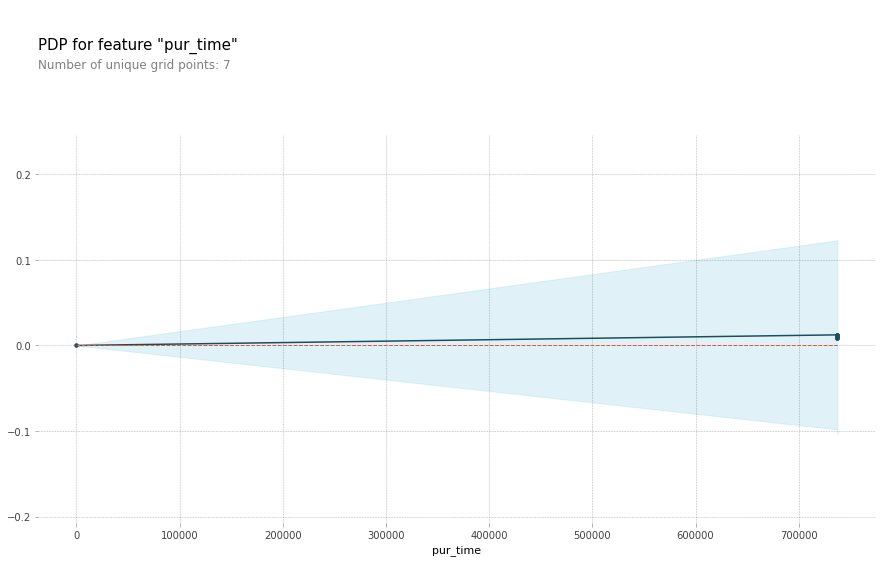

In [40]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

isolated = pdp_isolate(
        model=dt_smote,
        dataset=X_train,
        model_features=X_train.columns,
        feature='pur_time',
        grid_type='percentile',
        num_grid_points= 10
        )

pdp_plot(isolated, feature_name='pur_time');

### **Finding**
*   'pur_time' 구매한 시간은 구매 여부와 양의 상관 관계를 보입니다.